In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import load_dataset
import numpy as np 

In [3]:
imagenette = load_dataset(
    "frgfm/imagenette",
    "320px",
    split="validation",
    revision="4d512db"
)
imagenette

c:\Users\kenan\AppData\Local\Programs\Python\Python310\lib\site-packages\datasets\load.py:1429: FutureWarning: The repository for frgfm/imagenette contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/frgfm/imagenette
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 3925
})

In [14]:
labels = imagenette.info.features["label"].names

In [15]:
clip_labels = [f"A photo of {x}" for x in labels]
clip_labels

['A photo of tench',
 'A photo of English springer',
 'A photo of cassette player',
 'A photo of chain saw',
 'A photo of church',
 'A photo of French horn',
 'A photo of garbage truck',
 'A photo of gas pump',
 'A photo of golf ball',
 'A photo of parachute']

In [16]:
model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

device

'cuda'

In [18]:
label_tokens = processor(
    text=clip_labels,
    padding=True,
    images=None,
    return_tensors="pt"
).to(device)
label_tokens

{'input_ids': tensor([[49406,   320,  1125,   539,  1149,   634, 49407],
        [49406,   320,  1125,   539,  3469, 30117, 49407],
        [49406,   320,  1125,   539, 19717,  2477, 49407],
        [49406,   320,  1125,   539,  3946,  2425, 49407],
        [49406,   320,  1125,   539,  2735, 49407, 49407],
        [49406,   320,  1125,   539,  3461,  9607, 49407],
        [49406,   320,  1125,   539, 13760,  4629, 49407],
        [49406,   320,  1125,   539,  2474,  9173, 49407],
        [49406,   320,  1125,   539,  3096,  1069, 49407],
        [49406,   320,  1125,   539, 30122, 49407, 49407]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0]], device='cuda:0')}

In [26]:
label_emb = model.get_text_features(**label_tokens)
label_emb = label_emb.detach().cpu().numpy()
label_emb.shape


(10, 512)

In [27]:

label_emb = label_emb / np.linalg.norm(label_emb, axis=0)

In [28]:
np.max(label_emb)

0.881321

In [29]:
np.min(label_emb)

-0.89845777

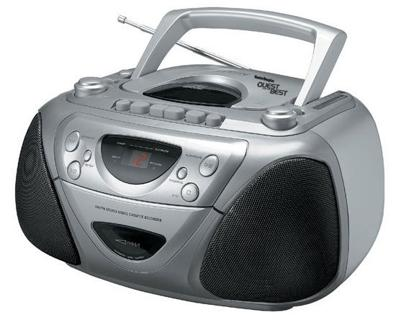

In [35]:
image = imagenette[4]["image"]
image

In [36]:
image = processor(
    text=None,
    images=image,
    return_tensors="pt"
)["pixel_values"].to(device)
image.shape

torch.Size([1, 3, 224, 224])

In [37]:
img_emb = model.get_image_features(image)
img_emb.shape

torch.Size([1, 512])

In [38]:
img_emb = img_emb.detach().cpu().numpy()

In [39]:
scores = np.dot(img_emb, label_emb.T)
scores.shape

(1, 10)

In [40]:
pred = np.argmax(scores)
pred

2

In [41]:
labels[pred]

'cassette player'

In [51]:
from utils.utils import read_image
import matplotlib.pyplot as plt
import cv2

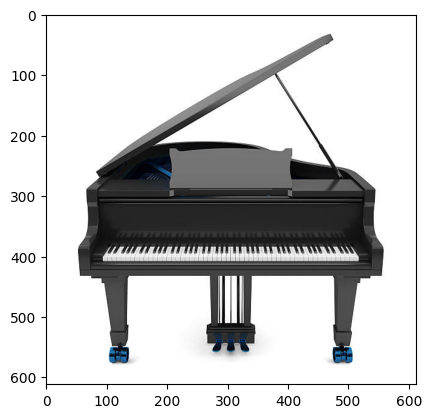

In [92]:
image = read_image(image_name="2.jpg")

plt.imshow(image)


In [93]:
image.shape

(612, 612, 3)

In [94]:
image = np.expand_dims(image, axis=0)
image.shape

(1, 612, 612, 3)

In [71]:
labels = ["A photo of a piano", "Someone playing the piano", "A photo of a guitar", "A photo of a piano in a white background",
          "A very big dog eating hotdogs", "A fluffy cat", "A photo of the earth from the dark space"]

In [72]:
labels = processor(
    text=labels,
    images=None,
    padding=True,
    return_tensors="pt"
).to(device)

In [73]:
text_emb = model.get_text_features(**labels)

In [75]:
text_emb = text_emb.detach().cpu().numpy()
text_emb.shape

(7, 512)

In [87]:
text_emb = text_emb / np.linalg.norm(text_emb, axis=0)

In [88]:
np.max(text_emb), np.min(text_emb)

(0.9482625, -0.9388161)

In [95]:
image = processor(
    text=None,
    images=image,
    return_tensors="pt"
)["pixel_values"].to(device)



In [96]:
image_emb = model.get_image_features(image)
image_emb.shape

torch.Size([1, 512])

In [97]:
image_emb = image_emb.detach().cpu().numpy()
image_emb.shape

(1, 512)

In [98]:
similarities = np.dot(image_emb, text_emb.T)

In [100]:
similarities

array([[20.363674 , 17.37013  ,  8.834323 , 22.327663 ,  1.1721393,
         4.0529566,  4.5252047]], dtype=float32)

In [103]:
index = np.argmax(similarities, axis=1).item()
index

3

In [105]:
labesl_ = ["A photo of a piano", "Someone playing the piano", "A photo of a guitar", "A photo of a piano in a white background",
          "A very big dog eating hotdogs", "A fluffy cat", "A photo of the earth from the dark space"]

In [106]:
labesl_[index]

'A photo of a piano in a white background'